# <a id="top_section"></a>

<div align='center'><font size="6" color="#000000"><b>Titanic Survival Prediction : The beginner's way !</b></font></div>
<hr>
<div align='center'><font size="5" color="#000000">Introduction</font></div>
<hr>

When I started doing this analysis my main goal was getting experience. I'm still learning and trying to improve my skills, so there is a great chance that there will be some areas for improvement.
<br><br>
In this notebook I will show you how a beginner (in this case ,me) approached the Titanic Survival prediction problem.I read a lot of notebooks of very experienced and helpful kagglers and watched some videos on youtube for better understanding. So without further ado , let's get this started!

### Here are the things I will try to cover in this Notebook:

- What is the survival rate for specific groups?
- Is there any relation between given info of passengers and their survival?
- Was women and children first policy in order?
- Having higher social status in helped people getting in life boats?
- The mustering order from captain was highly dependent on the class of the passengers, can we spot this  effect between pclass and the survival rates?
- What are the effects of family size?

- Can we predict if a passenger survived from the disaster with using machine learning techniques?

### If you liked this kernel feel free to upvote and leave feedback, thanks!

<a id="toc_section"></a>
## Table of Contents
* [Introduction](#top_section)
* [Importing all the Required Libraries](#section1)
* [Exploring the Data](#section2)
    - [Visualizing given dataset](#section3)
* [Building the Feature Engineering Machine](#section4)
    - [Merging Parch and SibSp](#section5)
    - [Converting Sex column to numerical type](#section6)
    - [Extracting Title from Name](#section7)
    - [Filling and Encoding the Fare feature](#section8)
    - [Encoding the Embarked feature](#section9)
    - [Filling and Encoding the Age feature](#section10)
    - [Do not make this mistake !](#section11)
    - [Dropping the unnecessary features](#section12)
* [Modelling](#section13)
* [Submission & Some Last Words](#sectionlst)


<a id="section1"></a>
## Importing the libraries

### [Back To Table of Contents](#toc_section)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let us also import all the sklearn libraries we might need 

In [2]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,learning_curve,cross_val_score

<a id="section2"></a>
## Exploring the data

### [Back To Table of Contents](#toc_section)

Let's read the data , both train and test one and to make sure that they are in the same format we will for the time being concatinate them so that both have the same operations

In [3]:
train=pd.read_csv('../input/titanic/train.csv')
test=pd.read_csv('../input/titanic/test.csv')
df=pd.concat([train,test],axis=0,ignore_index=True)
print(f'Train:{train.shape}\nTest:{test.shape}\nDf:{df.shape}')

Train:(891, 12)
Test:(418, 11)
Df:(1309, 12)


Mind taking a sneak peak in the dataset now ?

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The first thing we will do is see for any missing data in the dataset.

In [5]:
#columns with missing values
df.isnull().sum()[df.isnull().sum()>0]

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

Let's see the stats of our data now using the describe function (I just transposed it because i prefer it that way)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292


Now let's see the stats of the categorical features

In [7]:
# only describing the categorical columns
df.describe(exclude='number')

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


There is clearly alot of data missing in the age and cabin column , a few in embarked too , the one you see in survived is not really the missing data but the data we need to predict so don't worry about it.

We will take care of the missing data , but first we need to see how each feature is connected to one another and you'll see how it will help us to take care of the missing data as well as understand the data more clearly.

<a id="section3"></a>
## Visualizing given dataset

### [Back To Table of Contents](#toc_section)

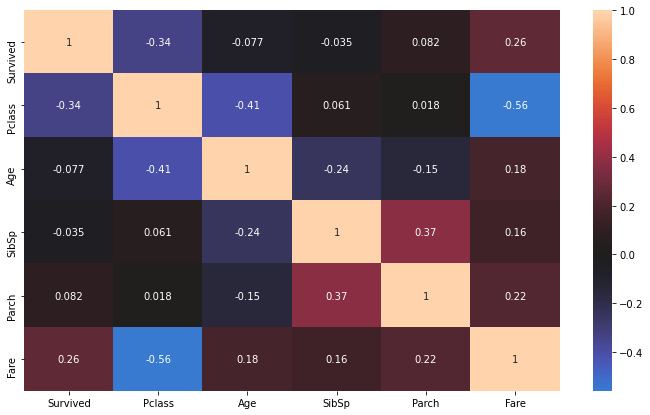

In [8]:
#Let's draw a heatmap of correlation between the features
plt.figure(figsize=(12,7))
sns.heatmap(df.drop('PassengerId',axis=1).corr(),annot=True,center=0)

As we can see from the heatmap , that the Survival is highly correlated to Patch,SibSp,Age,Sex,Fare and Pclass.

Now let's plot and analyze the age and survival correlation.

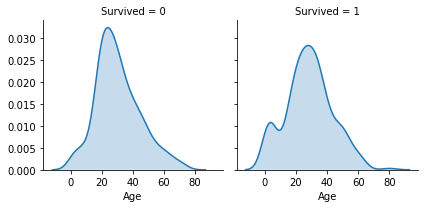

In [9]:
g=sns.FacetGrid(train,col='Survived').map(sns.distplot,'Age',hist=False,kde=True,rug=False,kde_kws={'shade':True})

Now let's plot and analyse how the Passenger Class(Pclass in dataset) affects survival chances of a person.

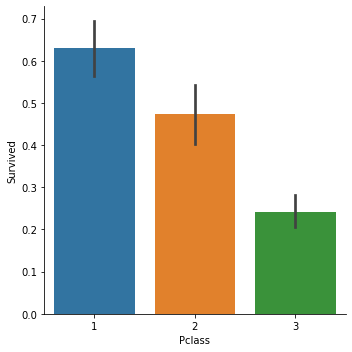

In [10]:
sns.catplot(x='Pclass',y='Survived',data=train,kind='bar')

What about the sex of a person , how does it affect a person's survival? Let's find out !

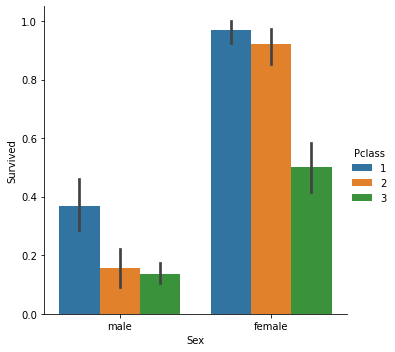

In [11]:
sns.catplot(x='Sex',y='Survived',hue='Pclass',data=train,kind='bar')

Does the Embarked feature also affect the survival chances, there only one way to find out , let's see!

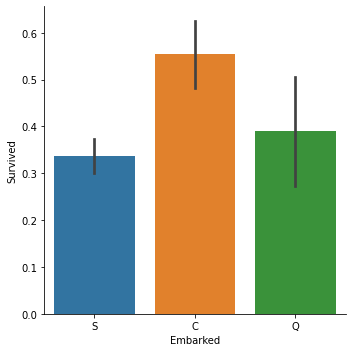

In [12]:
sns.catplot(x="Embarked", y="Survived", data=train, kind="bar")

<a id="section4"></a>
## Building the Feature Engineering Machine

### [Back To Table of Contents](#toc_section)


<a id="section5"></a>
### Merging Parch and SibSp


Let's combine the Parch and SibSp feature to form a better Family_size feature 

In [13]:
df['Family_Size']=df['Parch']+df['SibSp']
df.groupby('Family_Size')['Survived'].mean()

Family_Size
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

Now let's see how the Family Size of a person affects his/her chance of survival.

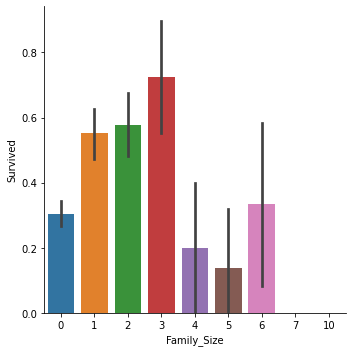

In [14]:
sns.catplot(x='Family_Size',y='Survived',data=df,kind='bar')

<a id="section6"></a>
### Converting Sex column to numerical type


Let's convert the Sex column from categorical to Numerical , will use the map function for this.

In [15]:
#converting the sex column into numerical column
df.Sex=df.Sex.map({'male':0,'female':1}).astype('int')

<a id="section7"></a>
### Extracting Title from Name


The Name feature is not really useful but we can use the Title of a person(such as Mr,Miss,etc) as a feature , so let's do it !

In [16]:
df['Title'] = df['Name']

for name_string in df['Name']:
    df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

df.replace({'Title': mapping}, inplace=True)

Let's see if the Title feature really is affecting the Survival chances or not!

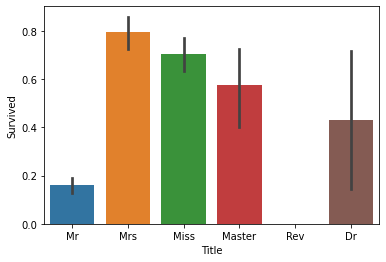

In [17]:
sns.barplot(x='Title',y='Survived',data=df.iloc[:len(train)])

<a id="section8"></a>
### Filling and Encoding the Fare feature


Let's see for missing values in the Fare column.

In [18]:
df[df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Title
1043,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,0,Mr


As there is only one missing value , we can easily fill it up by either mean or median of the column , I am using mean here.

In [19]:
df['Fare'].fillna(df['Fare'].mean(), inplace=True)

Now let's encode the Fare column into 5 categories.I am using LabelEncoder from sklearn here.

In [20]:
df['FareBin'] = pd.qcut(df['Fare'], 5)

label = LabelEncoder()
df['FareBin_Code'] = label.fit_transform(df['FareBin'])
df.drop(['Fare'], 1, inplace=True)

Let's see how the encoded fare column looks.

In [21]:
df['FareBin_Code'].value_counts()

0    275
3    263
4    259
2    258
1    254
Name: FareBin_Code, dtype: int64

<a id="section9"></a>
### Encoding the Embarked feature


Now we will use the get_dummy method of pandas to encode the Embarked column.

In [22]:
embarked=pd.get_dummies(df['Embarked'],drop_first=True)
df=pd.concat([df,embarked],axis=1)

<a id="section10"></a>
### Filling and Encoding the Age feature


Now , the time for taking care of the Age column is here, we have two options here either use Pclass or Title to help fill the missing age values , I first used the Pclass but , using the Title increased my score so here are both for you !

Here's how you can fill missing ages using the Pclass column as reference.

In [23]:
#  def fix_age(cols):
#     Age=cols[0]
#     Pclass=cols[1]
    
#     if pd.isnull(Age):
#         if Pclass==1:
#             return 37 
#         elif Pclass==2:
#             return 29
#         else:
#             return 24
#     else:
#         return Age 

In [24]:
# df['Age']=df[['Age','Pclass']].apply(fix_age,axis=1)

Here's how you can fill missing ages using the Title column as reference.(this yield better results for me)

In [25]:
# filling missing values in 'age' column
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']

for title in titles:
    age_to_impute = df.groupby('Title')['Age'].median()[titles.index(title)]
    df.loc[(df['Age'].isnull()) & (df['Title'] == title), 'Age'] = age_to_impute

Let's make sure it's done !

In [26]:
df['Age'].isnull().sum()

0

Now let us encode the age column into 4 parts. 

In [27]:
df['AgeBin'] = pd.qcut(df['Age'], 4)

label = LabelEncoder()
df['AgeBin_Code'] = label.fit_transform(df['AgeBin'])

We have done a lot of operations lately , let's see how our data looks like now.

In [28]:
df.sample(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Family_Size,Title,FareBin,FareBin_Code,Q,S,AgeBin,AgeBin_Code
150,151,0.0,2,"Bateman, Rev. Robert James",0,51.0,0,0,S.O.P. 1166,NaN,S,0,Rev,"(10.5, 21.679]",2,0,1,"(36.0, 80.0]",3
775,776,0.0,3,"Myhrman, Mr. Pehr Fabian Oliver Malkolm",0,18.0,0,0,347078,NaN,S,0,Mr,"(-0.001, 7.854]",0,0,1,"(0.169, 22.0]",0


In [29]:
df['AgeBin_Code'].value_counts()

1    452
0    392
3    292
2    173
Name: AgeBin_Code, dtype: int64

<a id="section11"></a>
### Do not make this mistake !

Now we are done with all the encoding and taking care of mising values stuff , let's drop the features that are not useful.

But wait what about the Cabin column , like you i also thought that with so many missing values , I should just drop it but i thought of something , made a column with people having cabin(entry with cabin !=Nan) and people not having a cabin (entry with cabin column = Nan) ,and it actually has a great effect on the survival chances.

So let's do it !

In [30]:
df.loc[(df['Cabin'].isnull()),'Cabin_status'] = 0
df.loc[(df['Cabin'].notnull()),'Cabin_status']=1
df.Cabin_status.astype('int')

0       0
1       1
2       0
3       1
4       0
       ..
1304    0
1305    1
1306    0
1307    0
1308    0
Name: Cabin_status, Length: 1309, dtype: int64

So , let me show you how the not so useful seeming Cabin is actually useful !

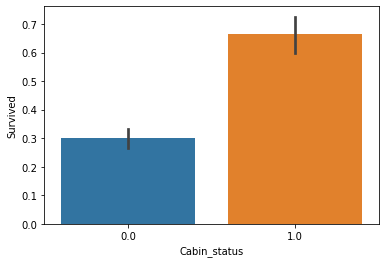

In [31]:
sns.barplot(x='Cabin_status',y='Survived',data=df.iloc[:len(train)])

So finally , let's drop all the unnecessary columns.

<a id="section12"></a>
### Dropping the unnecessary features


In [32]:
df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin','Embarked',
                 'FareBin', 'AgeBin', 'Survived', 'Title', 'Age'], axis = 1, inplace = True)

After all the dropped columns , our data must be clean and not-so-long , let's see for ourselves

In [33]:
df.sample(2)

,Pclass,Sex,Family_Size,FareBin_Code,Q,S,AgeBin_Code,Cabin_status
125,3,0,1,2,0,0,0,0.0
716,1,1,0,4,0,0,3,1.0


<a id="section13"></a>
# Modelling

Since preprocessing is done we are ready for training our models. We start with loading packages and splitting our transformed data so we have 22 features and and 891 observations to train our estimators. Our test set has 418 observations to make predictions.

### [Back To Table of Contents](#toc_section)

Now , we have to head towards the modelling and submision part , so let's split the data into it's initial train and test sets. 

In [34]:
X_train = df[:len(train)]
X_test = df[len(train):]

y_train = train['Survived']

In [35]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
kfold = StratifiedKFold(n_splits=8)

In [37]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [3,"sqrt", "log2"],
              "min_samples_split": [n for n in range(1, 9)],
              "min_samples_leaf": [5, 7],
              "bootstrap": [False, True],
              "n_estimators" :[200, 500],
              "criterion": ["gini", "entropy"]}

rf_param_grid_best = {"max_depth": [None],
              "max_features": [3],
              "min_samples_split": [4],
              "min_samples_leaf": [5],
              "bootstrap": [False],
              "n_estimators" :[200],
              "criterion": ["gini"]}

gs_rf = GridSearchCV(RFC, param_grid = rf_param_grid_best, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gs_rf.fit(X_train, y_train)

rf_best = gs_rf.best_estimator_
RFC.fit(X_train, y_train)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    3.0s finished


RandomForestClassifier()

In [38]:
print(f'RandomForest GridSearch best params: {gs_rf.best_params_}\n')
print(f'RandomForest GridSearch best score: {gs_rf.best_score_}')
print(f'RandomForest score:                 {RFC.score(X_train,y_train)}')

RandomForest GridSearch best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}

RandomForest GridSearch best score: 0.8636331491646203
RandomForest score:                 0.8855218855218855


In [39]:
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate':[0.05, 0.1], 
                  'reg_lambda':[0.3, 0.5],
                  'gamma': [0.8, 1],
                  'subsample': [0.8, 1],
                  'max_depth': [2, 3],
                  'n_estimators': [200, 300]
              }

xgb_param_grid_best = {'learning_rate':[0.1], 
                  'reg_lambda':[0.3],
                  'gamma': [1],
                  'subsample': [0.8],
                  'max_depth': [2],
                  'n_estimators': [300]
              }

gs_xgb = GridSearchCV(XGB, param_grid = xgb_param_grid_best, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gs_xgb.fit(X_train,y_train)
XGB.fit(X_train, y_train)

xgb_best = gs_xgb.best_estimator_


print(f'XGB GridSearch best params: {gs_xgb.best_params_}\n')
print(f'XGB GridSearch best score: {gs_xgb.best_score_}')
print(f'XGB score:                 {XGB.score(X_train,y_train)}')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


XGB GridSearch best params: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 0.3, 'subsample': 0.8}

XGB GridSearch best score: 0.8740276886791116
XGB score:                 0.8843995510662177


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    1.3s finished


<a id="sectionlst"></a>
#  Submission


### [Back To Table of Contents](#toc_section)

In [40]:
results=pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':RFC.predict(X_test)})
results.to_csv("submission.csv", header=True,index=False)

print("The submission file is ready, here's a sample of it!")
print(results.sample(2))

The submission file is ready, here's a sample of it!
     PassengerId  Survived
26           918         1
234         1126         1


# Some last words:

### Thank you for reading! I'm still a beginner and want to improve myself in every way I can. So if you have any ideas to feedback please let me know in the comments section!


<div align='center'><font size="5" color="#000000"><b>And again please vote if you liked this notebook so it can reach more people, Thanks!</b></font></div>

<img src="https://cloud.netlifyusercontent.com/assets/344dbf88-fdf9-42bb-adb4-46f01eedd629/7543b6dd-a4db-46d7-9a46-9755c6399b0e/puppy-thanks.jpg" alt="Thank you!" width="500" height="600">